# 🧠 Gated Attention in Transformers: A Complete Beginner's Guide

---

## Welcome!

This notebook will teach you about **Gated Attention**, an advanced technique used in modern AI language models (like ChatGPT, Claude, etc.). Don't worry if you've never worked with AI before — we'll explain everything from the ground up!

### What Will You Learn?

1. **What is Attention?** - The core mechanism that allows AI to understand language
2. **What is a Gate?** - A learned "switch" that controls information flow
3. **Why combine them?** - How gating makes attention smarter and more stable
4. **Hands-on Code** - Build and train a gated transformer for sentiment analysis

---

## 🎯 The Big Picture: What Problem Are We Solving?

Imagine you're reading a movie review:

> *"Despite the slow start, this movie was **unexpectedly brilliant** and left me in tears."*

As a human, you know this is a **positive** review because you focus on key words like "brilliant" and "tears" (happy tears!). But how does an AI learn to do this?

**Standard Attention** lets the AI look at all words and decide which ones are important. But it has a flaw: it always mixes the "global context" (what other words say) with the "local identity" (what each word means on its own) in a **fixed 50-50 ratio**.

**Gated Attention** adds a learnable "dimmer switch" that lets the AI decide:
- "For this word, I need more context from other words" → Gate opens (≈1)
- "For this word, I should trust its original meaning" → Gate closes (≈0)

This makes the AI smarter, more stable, and easier to interpret!

---

## 📦 Cell 1: Installing Required Libraries

### What This Cell Does:
This cell installs all the software packages (libraries) we need to build our AI model.

### Libraries Explained:

| Library | What It Does | Real-World Analogy |
|---------|-------------|--------------------|
| **torch** | The main deep learning framework (PyTorch) | Like a fully-equipped workshop for building AI |
| **torchvision** | Tools for image processing | Camera and photo editing tools |
| **torchaudio** | Tools for audio processing | Microphone and sound editing tools |
| **datasets** | Easy access to training data | A library card to access thousands of datasets |
| **transformers** | Pre-built AI models and tools | Pre-fabricated AI components you can use |
| **matplotlib** | Creating charts and visualizations | Graph paper and colored pencils |

### Why Do We Need These?
- **PyTorch (torch)**: This is the "engine" that does all the math. It can use your GPU (graphics card) to make calculations 10-100x faster than your CPU.
- **datasets**: We'll use the IMDB movie review dataset — 50,000 reviews labeled as positive or negative.
- **transformers**: Gives us a pre-trained tokenizer (converts text to numbers).
- **matplotlib**: We'll visualize what our gates are learning!

### Note:
You only need to run this cell once. After installation, the libraries stay on your system.

In [1]:
# pip install torch torchvision torchaudio datasets transformers matplotlib

In [2]:
# pip install ipywidgets

---

## 💻 Cell 2: Setting Up the Computing Device

### What This Cell Does:
This cell figures out what hardware your computer has and picks the fastest option for running AI calculations.

### The Three Types of Computing Devices:

| Device | Full Name | Speed | Who Has It? |
|--------|-----------|-------|-------------|
| **cuda** | NVIDIA GPU | 🚀🚀🚀 Fastest | PCs with NVIDIA graphics cards |
| **mps** | Metal Performance Shaders | 🚀🚀 Fast | MacBooks with M1/M2/M3 chips |
| **cpu** | Central Processing Unit | 🚀 Slower | All computers (fallback) |

### Why Does This Matter?

AI involves **millions of mathematical operations**. For example, our model will have:
- ~30,000 vocabulary words × 128 dimensions = 3.8 million numbers just for word embeddings!

GPUs (Graphics Processing Units) were originally designed for video games, but they're **perfect for AI** because they can do thousands of calculations **simultaneously** (in parallel).

### Code Breakdown:

```python
import torch  # Load the PyTorch library

# Check if Mac GPU (MPS) is available, otherwise use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print("Using device:", device)  # Tell us which device was selected
```

### What to Expect:
- On a MacBook with M1/M2/M3: `Using device: mps`
- On a PC with NVIDIA GPU: You'd change this to check for `cuda`
- On any computer without GPU: `Using device: cpu`

In [3]:
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


---

## 🧩 Cell 3: The Heart of Our Model — Gated Multi-Head Attention

### What This Cell Does:
This is the **most important cell** in the entire notebook! It defines the core innovation: **Gated Attention**.

---

### 📚 Background: What is Standard Attention?

Before we add gates, let's understand regular attention:

**The Attention Mechanism** answers the question: *"When processing word X, how much should I pay attention to words A, B, C, etc.?"*

#### Step-by-Step Example:

Consider the sentence: `"The cat sat on the mat"`

When processing the word "sat":
1. **Query (Q)**: "What am I looking for?" — The word "sat" creates a query
2. **Keys (K)**: "What do other words offer?" — Each word creates a key
3. **Values (V)**: "What information do they have?" — Each word's actual content

The attention mechanism:
1. Compares the Query to all Keys (using dot product)
2. Converts scores to probabilities (using softmax)
3. Takes a weighted average of Values

**Mathematical Formula:**

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right) V$$

Where:
- $Q$, $K$, $V$ = Query, Key, Value matrices
- $d$ = dimension size (we divide by $\sqrt{d}$ to keep numbers stable)
- $\text{softmax}$ = converts scores to probabilities (sum to 1)

---

### 👉 The Problem with Standard Transformers

In standard transformers, the attention output $H$ is combined with the original input $X$ using a **fixed formula**:

$$Z = X + H$$

This is called a **residual connection**. It's like saying:
- 50% = original word meaning ($X$)
- 50% = context from other words ($H$)

**The Problem**: This 50-50 split is **fixed** and **the same for every word**!

But think about it:
- The word "**amazing**" in a review might need 90% context (is it sarcastic?)
- The word "**the**" probably needs 90% original meaning (it's always just "the")

---

### 🎯 The Solution: Gated Attention

**Gated Attention** replaces the fixed 50-50 mixing with a **learnable gate**:

$$Y = G \odot H + (1 - G) \odot X$$

Where:
- $G$ = Gate values (learned, between 0 and 1)
- $\odot$ = Element-wise multiplication (multiply each dimension separately)
- $H$ = Attention output (global context)
- $X$ = Original input (local word identity)

**How the Gate is Computed:**

$$G = \sigma(XW_g + b_g)$$

Where:
- $\sigma$ = Sigmoid function (squashes any number to range 0-1)
- $W_g$ = Learnable weight matrix
- $b_g$ = Learnable bias

---

### 🎮 What Does the Gate Actually Do?

| Gate Value | Effect | When It's Useful |
|------------|--------|------------------|
| $G ≈ 1$ | Output ≈ Attention ($H$) | Sentiment words, reasoning, complex relationships |
| $G ≈ 0$ | Output ≈ Original ($X$) | Stopwords ("the", "a"), punctuation, noise |
| $G ≈ 0.5$ | 50-50 mix | Balanced need for both local and global info |

**Key Insight**: The gate operates **per-token AND per-dimension**!

If your model has 128 dimensions and 10 words:
- You get 10 × 128 = 1,280 individual gate values!
- Each dimension of each word can be gated differently!

---

### 🔢 Numerical Example

For the word "amazing" (simplified to 2 dimensions):

```
Original input:     X = [0.1, 0.9]
Attention output:   H = [0.8, 0.2]  
Learned gate:       G = [0.9, 0.1]  (the network learned these!)

Output: Y = G * H + (1-G) * X
        Y = [0.9×0.8 + 0.1×0.1, 0.1×0.2 + 0.9×0.9]
        Y = [0.72 + 0.01, 0.02 + 0.81]
        Y = [0.73, 0.83]
```

**Interpretation:**
- Dimension 1: Gate=0.9 → Mostly use attention (global context)
- Dimension 2: Gate=0.1 → Mostly keep original meaning (local identity)

---

### 🧠 Why Sigmoid for the Gate?

The **sigmoid function** $\sigma(x) = \frac{1}{1 + e^{-x}}$ is perfect because:

1. **Bounded**: Output is always between 0 and 1 (perfect for mixing ratios!)
2. **Smooth**: Small input changes → small output changes (stable gradients)
3. **Differentiable**: We can train it with backpropagation
4. **Soft switching**: Unlike hard 0/1 switches, allows gradual control

---

### 👁️ Multi-Head Attention

"Multi-head" means we run **multiple attention mechanisms in parallel**, each learning different patterns:

- **Head 1** might learn: syntax (grammar relationships)
- **Head 2** might learn: semantics (meaning relationships)  
- **Head 3** might learn: coreference (what "it" refers to)
- **Head 4** might learn: sentiment flow

We use `num_heads=4` in this code.

---

### 💻 Code Breakdown:

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class GatedMultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()  # Initialize parent class
        
        # Standard multi-head attention from PyTorch
        # batch_first=True means input shape is (batch, sequence, features)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        
        # THE GATE: A linear layer followed by sigmoid
        # Linear(dim, dim) means: input dim features → output dim features
        # This learns W_g and b_g from our formula: G = σ(X·W_g + b_g)
        self.gate = nn.Sequential(
            nn.Linear(dim, dim),  # Learns W_g and b_g
            nn.Sigmoid()          # Squashes to (0, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, dim)
        # Example: (8 reviews, 256 words each, 128 dimensions)
        
        # Step 1: Compute standard attention
        # Self-attention: query=key=value=x (comparing x with itself)
        attn_out, attn_weights = self.attn(x, x, x)
        # attn_out shape: (batch, seq, dim) — this is H in our formula
        # attn_weights: (batch, seq, seq) — who attended to whom
        
        # Step 2: Compute the gate values
        g = self.gate(x)  # shape: (batch, seq, dim)
        # g is between 0 and 1 for every element!
        
        # Step 3: Apply gated mixing formula
        # Y = G * H + (1 - G) * X
        out = g * attn_out + (1 - g) * x
        
        return out, attn_weights, g
```

---

### 🔬 Why This Works (Advanced Insights)

1. **Reduces Noisy Interactions**: Attention weights are often diffuse (spread out). The gate can block attention for dimensions where it's not useful.

2. **Stabilizes Training**: Standard residual connections can cause gradient problems in deep networks. Learnable gates help gradients flow better.

3. **Information Bottleneck**: The gate acts as a selective filter, reducing overfitting by only letting through useful information.

4. **Similar to LSTM Gates**: If you know LSTMs, this is conceptually similar to forget/input gates, but applied to attention instead of sequential memory.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GatedMultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.gate = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        attn_out, attn_weights = self.attn(x, x, x)
        g = self.gate(x)  # shape (batch, seq, dim)
        out = g * attn_out + (1 - g) * x
        return out, attn_weights, g

---

## 🏗️ Cell 4: Building a Complete Transformer Layer

### What This Cell Does:
This cell combines our gated attention with other essential components to create a **complete transformer layer**.

---

### 📚 Transformer Architecture Overview

A transformer layer has two main sub-components:

```
┌─────────────────────────────────────────────────────────┐
│                  TRANSFORMER LAYER                      │
├─────────────────────────────────────────────────────────┤
│  Input (X)                                              │
│     ↓                                                   │
│  ┌─────────────────────────────────┐                    │
│  │  1. GATED ATTENTION             │ ← Our custom!      │
│  │     - Multi-head self-attention │                    │
│  │     - Gated residual connection │                    │
│  └─────────────────────────────────┘                    │
│     ↓                                                   │
│  [Layer Normalization 1]                                │
│     ↓                                                   │
│  ┌─────────────────────────────────┐                    │
│  │  2. FEED-FORWARD NETWORK        │                    │
│  │     - Expand dimensions         │                    │
│  │     - Apply non-linearity       │                    │
│  │     - Contract dimensions       │                    │
│  └─────────────────────────────────┘                    │
│     ↓                                                   │
│  [Residual + Layer Normalization 2]                     │
│     ↓                                                   │
│  Output                                                 │
└─────────────────────────────────────────────────────────┘
```

---

### 🔄 Layer Normalization: Why We Need It

**Problem**: As data flows through neural networks, the numbers can become very large or very small (called "internal covariate shift"). This makes training unstable.

**Solution**: Layer Normalization standardizes the values:

$$\text{LayerNorm}(x) = \frac{x - \mu}{\sigma} \cdot \gamma + \beta$$

Where:
- $\mu$ = mean of the values
- $\sigma$ = standard deviation
- $\gamma$, $\beta$ = learnable scale and shift parameters

**Analogy**: It's like always keeping your bank account balance in a readable range (say, -1000 to +1000) instead of letting it swing from -1,000,000 to +1,000,000.

---

### 🧮 Feed-Forward Network: The "Thinking" Part

Attention finds relationships between words, but the **Feed-Forward Network (FFN)** processes each word's representation independently.

**Structure:**
```
Input (128 dim) → Expand (256 dim) → ReLU → Contract (128 dim)
```

**Why expand then contract?**
- Expanding creates a larger "working space" for computations
- The model can learn complex transformations in this larger space
- Contracting brings it back to the original size

**ReLU (Rectified Linear Unit):**
$$\text{ReLU}(x) = \max(0, x)$$

This simple function introduces **non-linearity** — without it, stacking layers would just be equivalent to one big linear transformation!

---

### 💻 Code Breakdown:

```python
class GatedTransformerLayer(nn.Module):
    def __init__(self, dim, num_heads, ff_dim):
        super().__init__()
        
        # Our custom gated attention from the previous cell
        self.attn = GatedMultiHeadAttention(dim, num_heads)
        
        # First layer normalization (after attention)
        self.norm1 = nn.LayerNorm(dim)
        
        # Feed-forward network: expand → activate → contract
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),   # 128 → 256 (expand)
            nn.ReLU(),                 # Non-linearity
            nn.Linear(ff_dim, dim)    # 256 → 128 (contract)
        )
        
        # Second layer normalization (after feed-forward)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        # Step 1: Apply gated attention
        attn_out, attn_w, gates = self.attn(x)
        
        # Step 2: Normalize (note: gated attention already includes residual!)
        x = self.norm1(attn_out)

        # Step 3: Feed-forward with residual connection
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)  # Traditional residual: x + ff_out
        
        return x, attn_w, gates
```

---

### 🤔 Why Two Different Residual Styles?

Notice something interesting:
- **Attention**: Uses **gated** residual (learned mixing)
- **Feed-Forward**: Uses **standard** residual (simple addition)

The attention sub-layer benefits more from gating because:
1. Attention aggregates information from **all positions** (complex interaction)
2. Feed-forward operates on **each position independently** (simpler)

You could add gating to the FF layer too, but research shows less benefit.

In [5]:
class GatedTransformerLayer(nn.Module):
    def __init__(self, dim, num_heads, ff_dim):
        super().__init__()
        self.attn = GatedMultiHeadAttention(dim, num_heads)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        attn_out, attn_w, gates = self.attn(x)
        x = self.norm1(attn_out)

        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x, attn_w, gates

---

## 🎬 Cell 5: The Complete Sentiment Classifier

### What This Cell Does:
This cell assembles everything into a **complete model** that can classify movie reviews as positive or negative.

---

### 🏛️ Full Architecture Overview

```
┌────────────────────────────────────────────────────────────────┐
│               GATED TRANSFORMER CLASSIFIER                     │
├────────────────────────────────────────────────────────────────┤
│                                                                │
│  Input: Token IDs [101, 2023, 3185, 2001, ...] (integers)      │
│     ↓                                                          │
│  ┌───────────────────────────────────────┐                     │
│  │  EMBEDDING LAYER                      │                     │
│  │  30,522 words × 128 dimensions        │                     │
│  │  Each word → 128-dim vector           │                     │
│  └───────────────────────────────────────┘                     │
│     ↓                                                          │
│  ┌───────────────────────────────────────┐                     │
│  │  TRANSFORMER LAYER 1                  │                     │
│  │  (Gated Attention + Feed-Forward)     │                     │
│  └───────────────────────────────────────┘                     │
│     ↓                                                          │
│  ┌───────────────────────────────────────┐                     │
│  │  TRANSFORMER LAYER 2                  │                     │
│  │  (Gated Attention + Feed-Forward)     │                     │
│  └───────────────────────────────────────┘                     │
│     ↓                                                          │
│  [Take first token's representation]                           │
│     ↓                                                          │
│  ┌───────────────────────────────────────┐                     │
│  │  CLASSIFICATION HEAD                  │                     │
│  │  128 dim → 2 classes (pos/neg)        │                     │
│  └───────────────────────────────────────┘                     │
│     ↓                                                          │
│  Output: [score_negative, score_positive]                      │
│                                                                │
└────────────────────────────────────────────────────────────────┘
```

---

### 📖 Word Embeddings: From Words to Numbers

Computers can't understand words directly — they need numbers!

**Embedding Layer** is a giant lookup table:
- **Input**: Word ID (e.g., 2023 = "this")
- **Output**: 128-dimensional vector representing that word's meaning

| Word    | ID   | Embedding (simplified to 4D) |
|---------|------|------------------------------|
| "the"   | 1996 | [0.1, -0.2, 0.4, 0.0]        |
| "good"  | 2204 | [0.8, 0.5, 0.3, 0.9]         |
| "bad"   | 2919 | [-0.7, 0.5, 0.3, -0.8]       |
| "movie" | 3185 | [0.2, 0.9, -0.1, 0.4]        |

**Key Insight**: Similar words get similar embeddings!
- "good" and "great" will have similar vectors
- "good" and "bad" will have different (maybe opposite) vectors

These embeddings are **learned** during training!

---

### 🎯 Pooling: From Sequence to Single Vector

After the transformer layers, we have:
- Shape: (batch_size, sequence_length, 128)
- Example: (8, 256, 128) = 8 reviews, each with 256 word representations

For classification, we need **one vector per review**.

**Solution**: Take the **first token's representation**
```python
pooled = x[:, 0]  # Shape: (batch_size, 128)
```

Why the first token? In BERT-style models, the first token (often `[CLS]`) is trained to aggregate information from the entire sequence. It's like the "summary token."

---

### 🏷️ Classification Head: Making the Final Decision

The final linear layer converts the 128-dim representation to 2 scores:

```python
self.cls = nn.Linear(dim, num_classes)  # 128 → 2
```

Output example: `[−0.5, 2.1]`
- Index 0: Score for "negative"
- Index 1: Score for "positive"

Higher score = more confident prediction. Here, the model predicts **positive**.

---

### 📊 Model Parameters Summary

| Component             | Calculation           | Parameters |
|-----------------------|-----------------------|------------|
| Embedding             | 30,522 × 128          | ~3.9M      |
| Attention (per layer) | Q,K,V matrices + gate | ~66K       |
| FFN (per layer)       | 128→256→128           | ~66K       |
| Layer Norms           | 128 × 2 × 2 layers    | ~1K        |
| Classifier            | 128 × 2               | 258        |
| **Total**             |                       | **~4M parameters** |

For comparison, GPT-3 has 175 **billion** parameters!

---

### 💻 Code Breakdown:

```python
class GatedTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, dim=128, num_heads=4, ff_dim=256, 
                 num_layers=2, num_classes=2):
        super().__init__()
        
        # Embedding: word ID → dense vector
        # vocab_size ≈ 30,522 for BERT tokenizer
        self.embed = nn.Embedding(vocab_size, dim)
        
        # Stack of transformer layers
        # ModuleList properly registers them for training
        self.layers = nn.ModuleList([
            GatedTransformerLayer(dim, num_heads, ff_dim)
            for _ in range(num_layers)  # Creates 2 layers
        ])
        
        # Final classifier: 128 → 2 (negative/positive)
        self.cls = nn.Linear(dim, num_classes)

    def forward(self, input_ids):
        # Convert word IDs to embeddings
        x = self.embed(input_ids)  # (batch, seq) → (batch, seq, dim)
        
        # Collect attention and gate maps for visualization
        attn_maps, gate_maps = [], []

        # Pass through each transformer layer
        for layer in self.layers:
            x, attn_w, gates = layer(x)
            attn_maps.append(attn_w)   # Save attention weights
            gate_maps.append(gates)     # Save gate values

        # Pool: take first token as sequence representation
        pooled = x[:, 0]  # (batch, seq, dim) → (batch, dim)
        
        # Classify
        logits = self.cls(pooled)  # (batch, dim) → (batch, 2)
        
        return logits, attn_maps, gate_maps
```

In [6]:
class GatedTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, dim=128, num_heads=4, ff_dim=256, num_layers=2, num_classes=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, dim)
        self.layers = nn.ModuleList([
            GatedTransformerLayer(dim, num_heads, ff_dim)
            for _ in range(num_layers)
        ])
        self.cls = nn.Linear(dim, num_classes)

    def forward(self, input_ids):
        x = self.embed(input_ids)
        attn_maps, gate_maps = [], []

        for layer in self.layers:
            x, attn_w, gates = layer(x)
            attn_maps.append(attn_w)
            gate_maps.append(gates)

        pooled = x[:, 0]
        logits = self.cls(pooled)
        return logits, attn_maps, gate_maps

---

## 📚 Cell 6: Loading and Preparing the Dataset

### What This Cell Does:
This cell downloads the IMDB movie review dataset and prepares it for training.

---

### 🎬 The IMDB Dataset

**IMDB** (Internet Movie Database) is a famous benchmark dataset for sentiment analysis:

| Split | Reviews | Purpose |
|-------|---------|--------|
| Train | 25,000 | Teach the model |
| Test | 25,000 | Evaluate performance |

**Labels:**
- 0 = Negative review
- 1 = Positive review

**Example Reviews:**

```
POSITIVE: "One of the best films I've ever seen. The acting was 
superb and the plot kept me engaged throughout."

NEGATIVE: "I want those two hours of my life back. The dialogue 
was wooden and the story made no sense."
```

---

### 🔤 Tokenization: Text → Numbers

Neural networks need numbers, not text. **Tokenization** converts text to token IDs.

**Example:**
```
Text:      "This movie was great!"
Tokens:    ["this", "movie", "was", "great", "!"]
Token IDs: [2023, 3185, 2001, 2307, 999]
```

**Why BERT Tokenizer?**
- Pre-trained vocabulary of ~30,522 tokens
- Handles subwords ("playing" → "play" + "##ing")
- Consistent with industry standard

---

### 📏 Padding and Truncation

**Problem**: Reviews have different lengths!
- Short: "Great film!" (2 words)
- Long: A 500-word essay

**Solution**: Make all sequences the same length (256 tokens)

| Original Length | Action |
|----------------|--------|
| < 256 | Pad with [PAD] tokens (ID=0) |
| > 256 | Truncate (cut off excess) |
| = 256 | Keep as is |

**Example:**
```
Original:  [2023, 3185, 2001]           (3 tokens)
Padded:    [2023, 3185, 2001, 0, 0, ...] (256 tokens)
                              ↑
                          PAD tokens
```

---

### 💻 Code Breakdown:

```python
from datasets import load_dataset
from transformers import AutoTokenizer

# Download IMDB dataset from Hugging Face
# This creates train/test splits automatically
dataset = load_dataset("imdb")

# Load pre-trained BERT tokenizer
# This knows how to convert text to token IDs
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define tokenization function
def encode(batch):
    return tokenizer(
        batch["text"],           # The review text
        padding="max_length",    # Pad short sequences
        truncation=True,          # Cut long sequences
        max_length=256            # Target length
    )

# Apply tokenization to all reviews
# batched=True processes multiple reviews at once (faster)
dataset = dataset.map(encode, batched=True)

# Configure dataset for PyTorch
# Only keep the columns we need
dataset.set_format(type="torch", columns=["input_ids", "label"])
```

---

### 📊 What the Data Looks Like After Processing

| Column | Shape | Type | Description |
|--------|-------|------|-------------|
| input_ids | (256,) | int64 | Token IDs for the review |
| label | () | int64 | 0 = negative, 1 = positive |

In [7]:
from datasets import load_dataset
from transformers import AutoTokenizer

dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def encode(batch):
    return tokenizer(
        batch["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=256
    )

dataset = dataset.map(encode, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "label"])

---

## 🚌 Cell 7: Creating Data Loaders

### What This Cell Does:
This cell creates **DataLoaders**, which organize data into batches for efficient training.

---

### 📦 Why Batching?

Instead of processing one review at a time, we process **8 reviews simultaneously** (a "batch").

**Benefits:**

| Aspect | Without Batching | With Batching (size=8) |
|--------|------------------|------------------------|
| GPU Utilization | ~5% | ~80% |
| Training Stability | Noisy gradients | Smoother gradients |
| Speed | Slow | 8x faster (approximately) |

**Analogy**: It's like a bus. Instead of making 8 individual car trips, you put 8 people on one bus!

---

### 🔀 Why Shuffle Training Data?

`shuffle=True` randomizes the order of training examples each epoch.

**Why it matters:**
- Without shuffling: Model might see all negative reviews first, then all positive
- This creates **batch bias** — gradients aren't representative of the whole dataset
- Shuffling ensures each batch is a random sample

**Note**: We don't shuffle the test set! We want consistent, reproducible evaluation.

---

### 💻 Code Breakdown:

```python
from torch.utils.data import DataLoader

# Training data loader
train_loader = DataLoader(
    dataset["train"],   # 25,000 training reviews
    batch_size=8,       # 8 reviews per batch
    shuffle=True        # Randomize order each epoch
)
# Total batches: 25,000 / 8 = 3,125 batches per epoch

# Test data loader
test_loader = DataLoader(
    dataset["test"],    # 25,000 test reviews
    batch_size=8        # Same batch size (no shuffling)
)
```

---

### 📊 Data Flow Summary

```
Raw Dataset (25,000 reviews)
        ↓
DataLoader (shuffle, batch)
        ↓
Batch 1: 8 reviews → Model → Update weights
Batch 2: 8 reviews → Model → Update weights
Batch 3: 8 reviews → Model → Update weights
        ...
Batch 3125: 8 reviews → Model → Update weights
        ↓
End of Epoch 1 (seen all 25,000 reviews once)
        ↓
Reshuffle → Start Epoch 2
```

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset["train"], batch_size=8, shuffle=True)
test_loader = DataLoader(dataset["test"], batch_size=8)

---

## 🏋️ Cell 8: Training the Model

### What This Cell Does:
This is where the **magic happens**! We train our model to classify movie reviews.

---

### 🎓 The Training Process

Training is an iterative process where the model learns by:
1. Making predictions (forward pass)
2. Measuring how wrong it was (loss calculation)
3. Adjusting its weights to do better (backward pass + optimization)

```
┌────────────────────────────────────────────────────────────────┐
│                    THE TRAINING LOOP                           │
├────────────────────────────────────────────────────────────────┤
│                                                                │
│  ┌───────────────┐                                             │
│  │ Input Batch   │  "This movie was great!"                    │
│  │ (8 reviews)   │  "Terrible waste of time"                   │
│  │               │  ...                                        │
│  └───────┬───────┘                                             │
│          ↓                                                     │
│  ┌───────────────┐                                             │
│  │  FORWARD PASS │  Model makes predictions                    │
│  │               │  [0.1, 0.9] → "positive"                    │
│  │               │  [0.8, 0.2] → "negative"                    │
│  └───────┬───────┘                                             │
│          ↓                                                     │
│  ┌───────────────┐                                             │
│  │  LOSS CALC    │  Compare to true labels                     │
│  │               │  Loss = 0.32 (how wrong we are)             │
│  └───────┬───────┘                                             │
│          ↓                                                     │
│  ┌───────────────┐                                             │
│  │ BACKWARD PASS │  Compute gradients                          │
│  │               │  (how to adjust each weight)                │
│  └───────┬───────┘                                             │
│          ↓                                                     │
│  ┌───────────────┐                                             │
│  │  OPTIMIZER    │  Update all weights                         │
│  │  STEP         │  (small steps toward better)                │
│  └───────┬───────┘                                             │
│          ↓                                                     │
│      Next Batch                                                │
│                                                                │
└────────────────────────────────────────────────────────────────┘
```

---

### 📉 Cross-Entropy Loss: Measuring "Wrongness"

**Cross-Entropy Loss** measures how far the predicted probabilities are from the true labels.

**Formula:**
$$\text{Loss} = -\sum_{i} y_i \log(p_i)$$

Where:
- $y_i$ = True label (1 for correct class, 0 otherwise)
- $p_i$ = Predicted probability for class $i$

**Intuition:**
- If model predicts 0.99 for the correct class → Loss ≈ 0.01 (very good!)
- If model predicts 0.01 for the correct class → Loss ≈ 4.6 (very bad!)

| Prediction for Correct Class | Loss |
|------------------------------|------|
| 0.99 | 0.01 |
| 0.90 | 0.11 |
| 0.50 | 0.69 |
| 0.10 | 2.30 |
| 0.01 | 4.60 |

---

### 🎯 Adam Optimizer: The Smart Weight Updater

**Adam** (Adaptive Moment Estimation) is the most popular optimizer. It's like a smart hiking guide:

- **Learning rate** (lr=3e-4 = 0.0003): How big each step is
- **Momentum**: Keeps going in the same direction if it's working
- **Adaptation**: Takes bigger steps in flat areas, smaller steps in steep areas

**Why 3e-4?**
- Too high (e.g., 0.1): Model learns fast but overshoots, unstable
- Too low (e.g., 0.00001): Model learns too slowly, stuck in bad spots
- 3e-4: Sweet spot for transformer models (found by researchers)

---

### 🔁 The Epoch Concept

**Epoch** = One complete pass through all training data

We train for 2 epochs:
- **Epoch 1**: Model sees all 25,000 reviews once (first learning)
- **Epoch 2**: Model sees all 25,000 reviews again (refinement)

More epochs = more learning, but risk of **overfitting** (memorizing instead of learning patterns).

---

### ⚡ GPU Memory Management

```python
ids = batch["input_ids"].to(device)
labels = batch["label"].to(device)
```

**`.to(device)`** moves data from CPU RAM to GPU memory.

| Location | Speed | Capacity |
|----------|-------|----------|
| CPU RAM | Slower | 16-64 GB |
| GPU Memory | Faster | 4-24 GB |

Data and model must be on the **same device** to work together!

---

### 🧹 Gradient Housekeeping

```python
opt.zero_grad()  # Clear old gradients
loss.backward()  # Compute new gradients
opt.step()       # Apply gradients to update weights
```

**Why zero_grad()?**
- PyTorch **accumulates** gradients by default
- Without clearing, old gradients mix with new ones
- This is a common source of bugs!

---

### 💻 Code Breakdown:

```python
# Initialize model and move to GPU
model = GatedTransformerClassifier(
    vocab_size=tokenizer.vocab_size  # ~30,522
).to(device)

# Initialize optimizer (Adam with learning rate 3e-4)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

# Define loss function (Cross-Entropy for classification)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(2):  # 2 epochs
    for batch in train_loader:  # 3,125 batches per epoch
        # Move data to GPU
        ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        # Forward pass: get predictions
        logits, _, _ = model(ids)  # We only need logits, ignore attention/gates
        
        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass and optimization
        opt.zero_grad()   # Clear old gradients
        loss.backward()   # Compute gradients
        opt.step()        # Update weights
        
    # Print progress after each epoch
    print(f"Epoch {epoch} | Loss {loss.item():.4f}")
```

---

### ⏱️ Expected Training Time

| Hardware | Time per Epoch | Total (2 epochs) |
|----------|---------------|------------------|
| M1/M2 Mac | ~15-20 min | ~30-40 min |
| NVIDIA GPU | ~5-10 min | ~10-20 min |
| CPU only | ~60+ min | ~2+ hours |

**Tip**: The loss should decrease over time. If it goes up or stays flat, something is wrong!

In [9]:
model = GatedTransformerClassifier(vocab_size=tokenizer.vocab_size).to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(2):
    for batch in train_loader:
        ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        logits, _, _ = model(ids)
        loss = criterion(logits, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f"Epoch {epoch} | Loss {loss.item():.4f}")

Epoch 0 | Loss 0.2386
Epoch 1 | Loss 0.5513


---

## 📊 Cell 9: Visualizing What the Gates Learned

### What This Cell Does:
This is the **most exciting cell** for understanding gated attention! We visualize what the gate learned to do.

---

### 🔬 Why Visualization Matters

Neural networks are often called "black boxes" — we know they work, but not **how**. Gated attention gives us a window into the model's decision-making:

- **High gate values (bright/yellow)**: Model relies on attention (global context)
- **Low gate values (dark/purple)**: Model relies on original input (local identity)

---

### 🖼️ Understanding the Heatmap

The visualization produces a **2D heatmap**:

```
                    Tokens (words in the sentence)
              "This" "movie" "was" "unexpectedly" "brilliant" ...
           ┌─────────────────────────────────────────────────────┐
Dimension 0│  ■■■■   ████   ■■     ████████       ████████       │
Dimension 1│  ■■     ██     ████   ████           ██████████     │
Dimension 2│  ████   ██     ██     ██████████     ████████████   │
    ...    │  ...    ...    ...    ...            ...            │
Dimension  │                                                     │
   127     │  ██     ████   ██     ████████       ████████████   │
           └─────────────────────────────────────────────────────┘
           
Legend:    ■■ = Dark (gate ≈ 0, use original)    
           ████ = Bright (gate ≈ 1, use attention)
```

---

### 🎯 What to Look For

**Pattern 1: Bright columns for sentiment words**
- Words like "brilliant", "amazing", "terrible" might show higher gate values
- The model needs context to understand if they're used genuinely or sarcastically

**Pattern 2: Dark columns for stopwords**
- Words like "the", "was", "a" might show lower gate values
- These words don't need much context — "the" is always just "the"

**Pattern 3: Dimension specialization**
- Some dimensions might be consistently bright (always use attention)
- Some might be consistently dark (always use original)
- This shows the model learned to specialize different dimensions!

---

### 💻 Code Breakdown:

```python
import matplotlib.pyplot as plt

def visualize_gates(model, text):
    # Step 1: Tokenize the input text
    # return_tensors="pt" gives us a PyTorch tensor
    tok = tokenizer(text, return_tensors="pt", padding=True).input_ids.to(device)
    
    # Step 2: Run the model and get gate values
    # We only care about gates, ignore logits and attention weights
    _, _, gates = model(tok)
    # gates is a list of gate tensors, one per layer
    # gates[0] = first layer's gates
    # gates[0][0] = first sample in batch

    # Step 3: Convert to numpy for plotting
    # .detach() removes gradient tracking
    # .cpu() moves from GPU to CPU
    # .numpy() converts tensor to numpy array
    layer_gates = gates[0][0].detach().cpu().numpy()
    # Shape: (sequence_length, 128)
    
    # Step 4: Create the heatmap
    # .T transposes so dimensions are on Y-axis, tokens on X-axis
    plt.imshow(layer_gates.T, aspect="auto", cmap="viridis")
    # aspect="auto" adjusts for rectangular data
    # cmap="viridis" is a perceptually uniform colormap
    
    # Step 5: Add colorbar and title
    plt.colorbar()  # Shows the value scale
    plt.xlabel("Token Position")
    plt.ylabel("Hidden Dimension")
    plt.title("Gate Activations (Layer 1)")
    plt.show()

# Test with a sample sentence
visualize_gates(model, "This movie was unexpectedly brilliant and emotional.")
```

---

### 🧪 Try These Experiments!

After running the cell, try visualizing different sentences:

```python
# Positive review
visualize_gates(model, "An absolute masterpiece that moved me to tears.")

# Negative review
visualize_gates(model, "The worst movie I have ever seen in my life.")

# Mixed/complex review
visualize_gates(model, "Despite the slow start, it turned out to be brilliant.")

# Sarcastic review
visualize_gates(model, "Oh great, another sequel nobody asked for.")
```

Compare the patterns! Do you see differences based on sentiment?

---

### 🔍 Reading the Colorbar

The colorbar on the right shows the mapping:

| Color | Value | Meaning |
|-------|-------|---------|
| Dark Purple | 0.0 - 0.3 | Ignore attention, keep original |
| Teal/Green | 0.3 - 0.6 | Mix both sources |
| Yellow | 0.6 - 1.0 | Trust attention, use context |

**Note**: In a well-trained model, you should see a **mix of colors**, showing the model learned when to use each strategy!

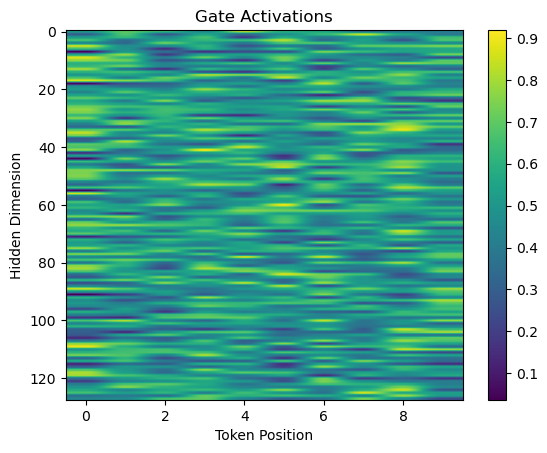

In [11]:
import matplotlib.pyplot as plt

def visualize_gates(model, text):
    tok = tokenizer(text, return_tensors="pt", padding=True).input_ids.to(device)
    _, _, gates = model(tok)

    layer_gates = gates[0][0].detach().cpu().numpy()
    plt.imshow(layer_gates.T, aspect="auto", cmap="viridis")
    plt.colorbar()
    plt.xlabel("Token Position")
    plt.ylabel("Hidden Dimension")
    plt.title("Gate Activations")
    plt.show()

visualize_gates(model, "This movie was unexpectedly brilliant and emotional.")

---

## 🎓 Summary: What You've Learned

Congratulations! You've built a **Gated Attention Transformer** from scratch!

### Key Concepts Recap

| Concept | What It Does | Why It Matters |
|---------|--------------|----------------|
| **Attention** | Lets tokens "look at" other tokens | Captures relationships in text |
| **Gating** | Learns to mix local vs. global info | Smarter, more stable transformers |
| **Residual Connections** | Preserves original information | Enables deep networks to train |
| **Layer Normalization** | Stabilizes internal values | Faster, more reliable training |
| **Feed-Forward Network** | Transforms each position | Adds computational power |

### The Gated Attention Formula (One Last Time!)

$$Y = \underbrace{G}_{\text{learned gate}} \odot \underbrace{H}_{\text{attention output}} + \underbrace{(1 - G)}_{\text{inverse gate}} \odot \underbrace{X}_{\text{original input}}$$

This simple formula is the key innovation that makes transformers:
- ✅ More stable (better gradient flow)
- ✅ More interpretable (we can visualize gates)
- ✅ More flexible (learns when to use attention)

---

## 🚀 Next Steps

Want to go deeper? Here are some ideas:

1. **Add gating to the Feed-Forward layer** — Does it help?
2. **Increase model size** — More layers, more heads, larger dimensions
3. **Evaluate on test set** — What's the actual accuracy?
4. **Visualize attention weights** — Not just gates, but what the model attends to
5. **Try other datasets** — Sentiment analysis on Twitter, product reviews, etc.

---

## 📚 References

- [Attention Is All You Need](https://arxiv.org/abs/1706.03762) — The original transformer paper
- [Gated Transformer-XL](https://arxiv.org/abs/1910.06764) — Paper introducing gated attention
- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html) — Official docs
- [Hugging Face Transformers](https://huggingface.co/docs/transformers/) — Industry-standard library

Happy learning! 🎉